### Try It: Comparing Feature Selection Methods

In this module, you have seen two ways to select features.  The first approach is using sequential feature selection to sequentially add or delete features and only use those that improve the model.  The second approach is using a regularized model to identify features based on non-zero coefficients.  This activity focuses on comparing variations of both these methods.  

You will use both the `SequentialFeatureSelection` and `RFE` (recursive feature elimination) to build and compare regression models.  Consider the following 6 feature selection methods -- leave all other arguments to default besides the `estimator` and `n_features_to_select` arguments:

- `Ridge` regressor to extract coefficients
- `SequentialFeatureSelection` using the `Lasso` to select 4 features.
- `RFE` using `Lasso` to select 4 features.

For each of these, fit the training data `X_train`, `y_train` below.  Compare the magnitude of the results of your `Ridge` model to those that result from feature selection methods.  

#### The Data

For this problem a dataset with information on red wine chemical compositions and their quality is given.  Your goal is to use the properties of the wine to predict the quality.  Below, the data is loaded and train/test splits constructed.

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel, f_regression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import researchpy as rp 

import warnings
from sklearn import set_config
set_config(display="diagram") #setting this will display your pipelines as seen above

warnings.filterwarnings("ignore")


In [27]:
df = pd.read_csv("C:/Users/Luswata/Dropbox/ML_AI_UCBerkeley/Data/winequality-red.csv", sep = ',')
df.shape

(1599, 12)

In [28]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [29]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [30]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [32]:
rp.summary_cat(df['quality'])

,Variable,Outcome,Count,Percent
0,quality,5,681,42.59
1,,6,638,39.90
2,,7,199,12.45
3,,4,53,3.31
4,,8,18,1.13
5,,3,10,0.63


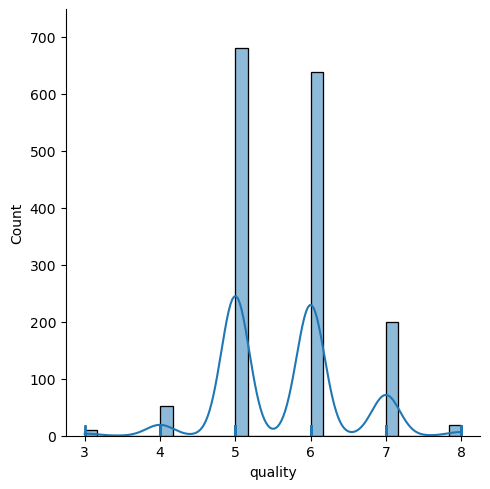

In [35]:
sns.displot(df["quality"], kde = True, rug = True)

In [36]:
# Identify and drop any duplicated records
duplicates = df[df.duplicated()]
df.drop_duplicates(inplace=True)
df.shape

(1359, 12)

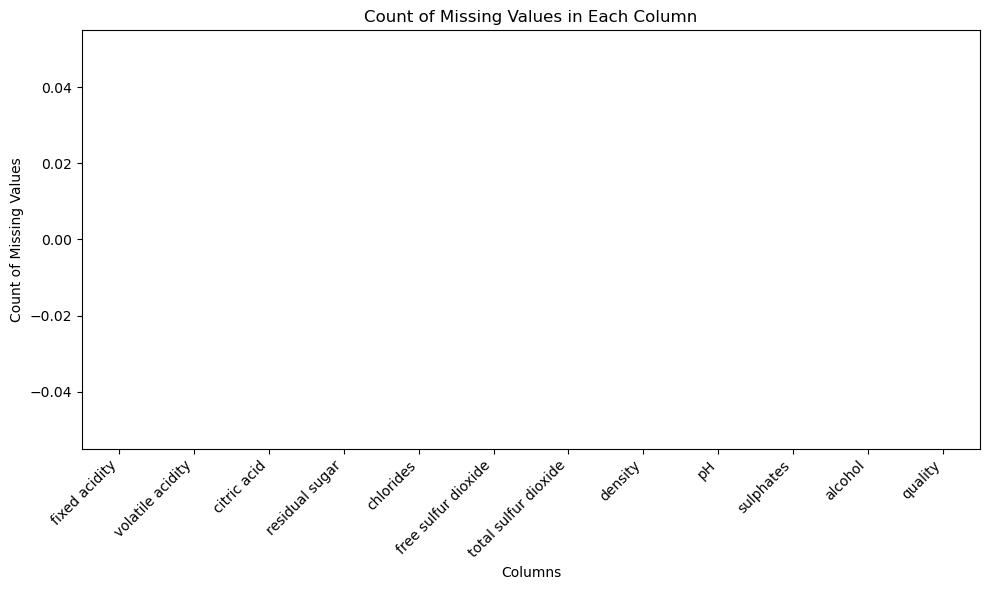

In [37]:
# Check misingness rates 
missing_values_count = df.isnull().sum().sort_values()

plt.figure(figsize=(10, 6))
missing_values_count.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Count of Missing Values')
plt.title('Count of Missing Values in Each Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot (optional)
plt.show()

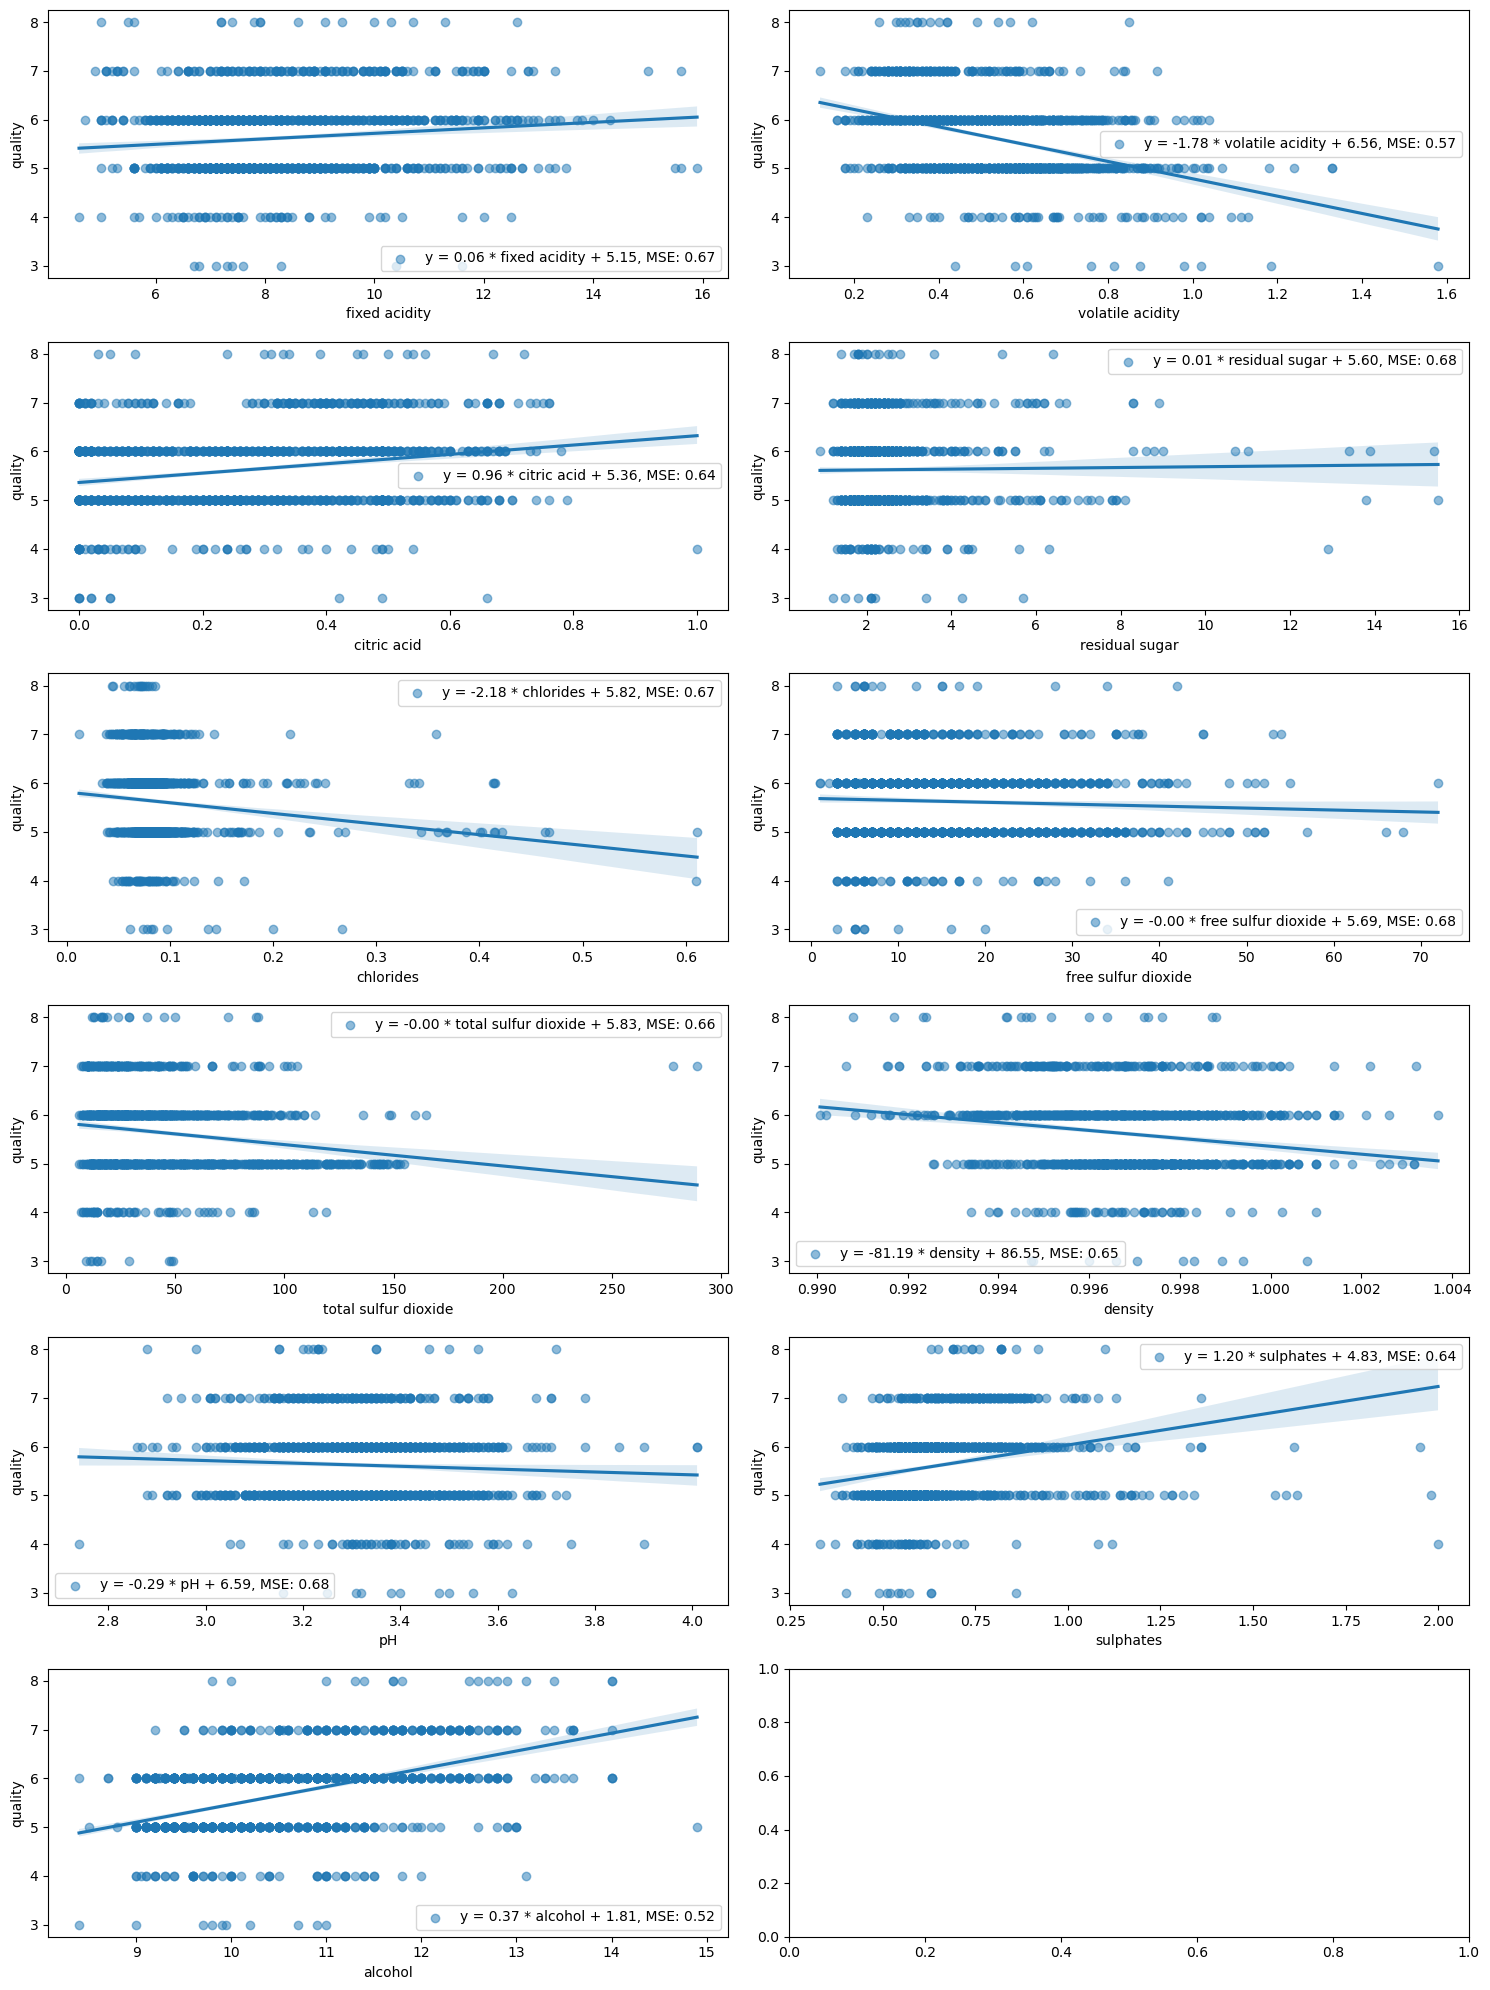

In [92]:
# Bivariate modeling & visualizations

# Define predictors (X) and target variable (y)

X = df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]
y = df['quality']

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Create subplots for each predictor
fig, axes = plt.subplots(6, 2, figsize=(15, 20))
axes = axes.flatten()

# Plot each predictor against y with regression line
for i, predictor in enumerate(X.columns):
    sns.regplot(x=predictor, y=y, data=df, ax=axes[i], scatter_kws={'alpha':0.5})
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_imputed[:, i].reshape(-1, 1), y)
    
    # Make predictions
    predictions = model.predict(X_imputed[:, i].reshape(-1, 1))
    
    # Calculate and display Mean Squared Error (MSE)
    mse = mean_squared_error(y, predictions)
    
    # Get slope (m) and intercept (b) of the regression line
    m = model.coef_[0]
    b = model.intercept_
    
    # Add equation to legend
    equation = f'y = {m:.2f} * {predictor} + {b:.2f}, MSE: {mse:.2f}'
    axes[i].legend([equation])

plt.tight_layout()
plt.show()


In [80]:
# Split the dataset
X = df.drop('quality', axis = 1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [81]:
# measure of collinearity using VIF
def vif(exogs, df):
    vif_dict = {}

    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = df[not_exog], df[exog]

        r_squared = LinearRegression().fit(X,y).score(X,y)

        # calculate VIF
        vif = 1/(1-r_squared)
        vif_dict[exog] = vif

    return pd.DataFrame({"VIF": vif_dict})

In [82]:
vif(X.columns, X).sort_values(by = 'VIF', ascending = False)

,VIF
fixed acidity,7.880951
density,6.281009
pH,3.397407
alcohol,3.140944
citric acid,3.124679
total sulfur dioxide,2.216688
free sulfur dioxide,1.950922
volatile acidity,1.777884
residual sugar,1.641987
chlorides,1.530769


In [83]:
# Pipeline for Ridge Regression
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

# Pipeline for Sequential Feature Selection (SFS) with Lasso
sfs_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sfs', SequentialFeatureSelector(estimator=Lasso(alpha=0.1), n_features_to_select=4, direction='backward'))
])

# Pipeline for Recursive Feature Elimination (RFE) with Lasso
rfe_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=Lasso(alpha=0.1), n_features_to_select=4))
])


In [84]:
# Fit Ridge regression and extract coefficients
ridge_pipeline.fit(X_train, y_train)
ridge_coefs = ridge_pipeline.named_steps['ridge'].coef_

ridge_features = np.count_nonzero(ridge_coefs)

# Evaluate models
ridge_predictions = ridge_pipeline.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)


# Fit Sequential Feature Selection
sfs_pipeline.fit(X_train, y_train)
selected_features_sfs = X_train.columns[sfs_pipeline.named_steps['sfs'].get_support()]

# Fit RFE
rfe_pipeline.fit(X_train, y_train)
selected_features_rfe = X_train.columns[rfe_pipeline.named_steps['rfe'].support_]

# Print results
print("Ridge Regression Coefficients:")
print(pd.Series(ridge_coefs, index=X_train.columns).sort_values())
print("\nRidge Regression MSE:", ridge_mse)
print("Ridge Regression R-squared:", ridge_r2)


print("\n\nSequential Feature Selection Coefficients:")

print("\nSelected features using Sequential Feature Selection (SFS):", selected_features_sfs)

print("\nSelected features using RFE:")
print(selected_features_rfe)




Ridge Regression Coefficients:
volatile acidity       -0.176239
total sulfur dioxide   -0.131272
pH                     -0.128590
chlorides              -0.101312
fixed acidity          -0.069136
citric acid            -0.004365
residual sugar         -0.002469
density                 0.040403
free sulfur dioxide     0.057179
sulphates               0.153616
alcohol                 0.327493
dtype: float64

Ridge Regression MSE: 0.40645654803331266
Ridge Regression R-squared: 0.3986205609469873
 Sequential Feature Selection Coefficients:

Selected features using Sequential Feature Selection (SFS): Index(['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol'], dtype='object')

Selected features using RFE:
Index(['volatile acidity', 'pH', 'sulphates', 'alcohol'], dtype='object')


In [85]:
# Sequential Feature Selection (SFS)

X = df[selected_features_sfs]
y = df['quality']

# Step 1: Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Fit the model using the modified training set
model = LinearRegression()
model.fit(X_train, y_train)

# Get parameter estimates (coefficients) and p-values
coefficients = model.coef_
intercept = model.intercept_

# Perform OLS regression using statsmodels to get p-values
X_train_with_intercept = sm.add_constant(X_train)  # Add intercept term
model_sm = sm.OLS(y_train, X_train_with_intercept).fit()
p_values = model_sm.pvalues

f_value = model_sm.fvalue
f_pvalue = model_sm.f_pvalue  # F-test p-value

r_squared = model_sm.rsquared
adj_r_squared = model_sm.rsquared_adj

# Predict on the test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Calculate Mean Squared Error (MSE)
val_mse = mean_squared_error(y_val, y_val_pred)

# Output parameter estimates, p-values, equation, and MSE
print("SFS Parameter Estimates:")
for feature, coef, p_value in zip(X_train.columns, coefficients, p_values):
    print(f"{feature}: Coef = {coef:.4f}, p-value = {p_value:.4f}")
print(f"Intercept: {intercept:.4f}")

# Construct the equation
equation = f"y = {intercept:.4f} + "
for feature, coef in zip(X_train.columns, coefficients):
    equation += f"({coef:.4f} * {feature}) + "
equation = equation[:-3]  # Remove the trailing '+'

print("\nR-squared:", r_squared)
print("  Adjusted R-squared:", adj_r_squared)

print("F-value:", f_value)
print("F-test p-value:", f_pvalue)

print(f"\nEquation: {equation}")
print(f"Mean Squared Error (MSE) on Validation Set: {val_mse:.4f}")
print(f"Mean Squared Error (MSE) on Test Set: {test_mse:.4f}")

sfs_test_mse = test_mse
sfs_r_squared = r_squared
sfs_f_value = f_value
sfs_f_pvalue = f_pvalue

# Count non-zero coefficients
sfs_features = np.count_nonzero(coefficients)


SFS Parameter Estimates:
volatile acidity: Coef = -1.0474, p-value = 0.0000
total sulfur dioxide: Coef = -0.0029, p-value = 0.0000
sulphates: Coef = 0.6690, p-value = 0.0002
alcohol: Coef = 0.2909, p-value = 0.0000
Intercept: 2.8532

R-squared: 0.3245718343171865
  Adjusted R-squared: 0.32123638658541953
F-value: 97.3098247728325
F-test p-value: 1.2636296498304507e-67

Equation: y = 2.8532 + (-1.0474 * volatile acidity) + (-0.0029 * total sulfur dioxide) + (0.6690 * sulphates) + (0.2909 * alcohol)
Mean Squared Error (MSE) on Validation Set: 0.4750
Mean Squared Error (MSE) on Test Set: 0.4267


In [86]:
# RFE

X = df[selected_features_rfe]
y = df['quality']

# Step 1: Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Fit the model using the modified training set
model = LinearRegression()
model.fit(X_train, y_train)

# Get parameter estimates (coefficients) and p-values
coefficients = model.coef_
intercept = model.intercept_

# Perform OLS regression using statsmodels to get p-values
X_train_with_intercept = sm.add_constant(X_train)  # Add intercept term
model_sm = sm.OLS(y_train, X_train_with_intercept).fit()
p_values = model_sm.pvalues

f_value = model_sm.fvalue
f_pvalue = model_sm.f_pvalue  # F-test p-value

r_squared = model_sm.rsquared
adj_r_squared = model_sm.rsquared_adj

# Predict on the test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Calculate Mean Squared Error (MSE)
val_mse = mean_squared_error(y_val, y_val_pred)

# Output parameter estimates, p-values, equation, and MSE
print("RFE Parameter Estimates:")
for feature, coef, p_value in zip(X_train.columns, coefficients, p_values):
    print(f"{feature}: Coef = {coef:.4f}, p-value = {p_value:.4f}")
print(f"Intercept: {intercept:.4f}")

# Construct the equation
equation = f"y = {intercept:.4f} + "
for feature, coef in zip(X_train.columns, coefficients):
    equation += f"({coef:.4f} * {feature}) + "
equation = equation[:-3]  # Remove the trailing '+'

print("\nR-squared:", r_squared)
print("  Adjusted R-squared:", adj_r_squared)

print("F-value:", f_value)
print("F-test p-value:", f_pvalue)

print(f"\nEquation: {equation}")
print(f"Mean Squared Error (MSE) on Validation Set: {val_mse:.4f}")
print(f"Mean Squared Error (MSE) on Test Set: {test_mse:.4f}")

rfe_test_mse = test_mse
rfe_r_squared = r_squared
rfe_f_value = f_value
rfe_f_pvalue = f_pvalue

# Count non-zero coefficients
rfe_features = np.count_nonzero(coefficients)


RFE Parameter Estimates:
volatile acidity: Coef = -0.9864, p-value = 0.0000
pH: Coef = -0.4610, p-value = 0.0000
sulphates: Coef = 0.5322, p-value = 0.0072
alcohol: Coef = 0.3295, p-value = 0.0005
Intercept: 3.9019

R-squared: 0.3188927704186235
  Adjusted R-squared: 0.3155292779268637
F-value: 94.81001405529197
F-test p-value: 3.6874225814055204e-66

Equation: y = 3.9019 + (-0.9864 * volatile acidity) + (-0.4610 * pH) + (0.5322 * sulphates) + (0.3295 * alcohol)
Mean Squared Error (MSE) on Validation Set: 0.4748
Mean Squared Error (MSE) on Test Set: 0.4250


In [88]:
# Compare MSE and R-squared of Ridge Regression with SFS and RFE
results = pd.DataFrame({
    'Method': ['Ridge Regression', 'Sequential Feature Selection (SFS)', 'RFE'],
    'MSE': [ridge_mse, sfs_test_mse, rfe_test_mse],        
    'R-squared': [ridge_r2, sfs_r_squared, rfe_r_squared],  
    'N-Features': [ridge_features, sfs_features, rfe_features]      
})

# Display results
print("\nComparison of Models:")
print(results)



Comparison of Models:
                               Method       MSE  R-squared  N-Features
0                    Ridge Regression  0.406457   0.398621          11
1  Sequential Feature Selection (SFS)  0.426671   0.324572           4
2                                 RFE  0.425006   0.318893           4
